<a href="https://colab.research.google.com/github/NehaSontakk/BATH-Prokka-Comparison/blob/main/Length_analysis_TO_do_Aug5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Analysis

#### Area of annotation covered by Prokka

In [ ]:
# Setup and Reading FASTA File
bath_protein['seq_id'] = bath_protein['target name']

fasta_file = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Examples/bin82/bin82 MAG Data/bin.82.fa.fna'

contigs_list = []
with open(fasta_file, "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        contigs_list.append({'seq_id': record.id, 'length': len(record.seq)})

contigs_info = pd.DataFrame(contigs_list)

annotated_prokka_proteins = prokka_proteins[prokka_proteins['product'] != 'hypothetical protein']
print("Number of annotated proteins",annotated_prokka_proteins.shape)
prodigal_orf = prokka_proteins[prokka_proteins['product'] == 'hypothetical protein']
print("Number of nonannotated proteins",prodigal_orf.shape)

print(contigs_info)

Number of annotated proteins (419, 18)
Number of nonannotated proteins (208, 18)
          seq_id  length
0   k127_1013475  183529
1   k127_2417308   46544
2   k127_1836396   58147
3     k127_39946   74930
4   k127_1041423   87228
5   k127_3066123  178996
6   k127_2074107  287621
7   k127_2086219  105609
8    k127_486726  181032
9    k127_507392   20147
10   k127_888825   99971
11  k127_2906854   39782
12   k127_533492  131788
13  k127_1346442   42043
14   k127_922904  133853
15  k127_3167081   24238
16   k127_748425  125518
17  k127_1768858  164989
18   k127_762480   77429
19   k127_795063   57992
20   k127_797108  146649


In [ ]:
def calculate_covered_length(df, seq_id):
    covered_points = set()
    for _, row in df[df['seq_id'] == seq_id].iterrows():
        start, end = row['start'], row['end']
        interval_points = set(range(start, end + 1))
        covered_points |= interval_points
    return len(covered_points)

In [ ]:
bath_protein = pd.concat([pos_strand,neg_strand])
bath_protein['seq_id'] = bath_protein['target name']
for _, contig in contigs_info.iterrows():
    seq_id = contig['seq_id']
    contig_length = contig['length']
    # Calculate covered length for Prokka and BATH annotations
    total_unannotated = calculate_covered_length(prodigal_orf, seq_id)
    total_covered_prokka = calculate_covered_length(annotated_prokka_proteins, seq_id)
    total_covered_bath = calculate_covered_length(bath_protein, seq_id)
    uncovered_length_prodigal = contig_length - total_unannotated
    uncovered_length_prokka = contig_length - total_covered_prokka
    uncovered_length_bath = contig_length - total_covered_bath
    contig_uncovered = contig_length - total_covered_prokka - total_unannotated
    print("Total left:", contig_uncovered)
    print(f"Contig {seq_id}: Prokka ORF = {total_unannotated}, Prokka ORF = {uncovered_length_prodigal}")
    print(f"Contig {seq_id}: BATH covered = {total_covered_bath}, BATH Uncovered = {uncovered_length_bath}")
    print(f"Contig {seq_id}: Prokka covered = {total_covered_prokka}, Prokka Uncovered = {uncovered_length_prokka}")

Total left: 20472
Contig k127_1013475: Prokka ORF = 75497, Prokka ORF = 108032
Contig k127_1013475: BATH covered = 77734, BATH Uncovered = 105795
Contig k127_1013475: Prokka covered = 87560, Prokka Uncovered = 95969
Total left: 6562
Contig k127_2417308: Prokka ORF = 17088, Prokka ORF = 29456
Contig k127_2417308: BATH covered = 19806, BATH Uncovered = 26738
Contig k127_2417308: Prokka covered = 22894, Prokka Uncovered = 23650
Total left: 7049
Contig k127_1836396: Prokka ORF = 25776, Prokka ORF = 32371
Contig k127_1836396: BATH covered = 27130, BATH Uncovered = 31017
Contig k127_1836396: Prokka covered = 25322, Prokka Uncovered = 32825
Total left: 9731
Contig k127_39946: Prokka ORF = 30903, Prokka ORF = 44027
Contig k127_39946: BATH covered = 31556, BATH Uncovered = 43374
Contig k127_39946: Prokka covered = 34296, Prokka Uncovered = 40634
Total left: 13358
Contig k127_1041423: Prokka ORF = 37341, Prokka ORF = 49887
Contig k127_1041423: BATH covered = 36213, BATH Uncovered = 51015
Contig 

In [ ]:
contigs_info['total_prodigal'] = 0
contigs_info['total_covered_prokka'] = 0
contigs_info['total_covered_bath'] = 0
contigs_info['total_uncovered_prokka'] = 0
contigs_info['total_uncovered_bath'] = 0
contigs_info['contig_length'] = 0

for _, contig in contigs_info.iterrows():
    seq_id = contig['seq_id']
    contig_length = contig['length']

    total_prodigal = calculate_covered_length(prodigal_orf, seq_id)
    total_covered_prokka = calculate_covered_length(annotated_prokka_proteins, seq_id)
    total_covered_bath = calculate_covered_length(bath_protein, seq_id)

    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'total_prodigal'] = total_prodigal
    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'total_covered_prokka'] = total_covered_prokka
    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'total_covered_bath'] = total_covered_bath
    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'contig_length'] = contig['length']


contigs_info['percent_covered_prokka'] = (contigs_info['total_covered_prokka'] / contigs_info['contig_length']) * 100
contigs_info['percent_covered_prodigal'] = (contigs_info['total_prodigal'] / contigs_info['contig_length']) * 100
contigs_info['percent_uncovered_prokka'] = 100 - contigs_info['percent_covered_prokka'] - contigs_info['percent_covered_prodigal']

contigs_info['percent_covered_bath'] = (contigs_info['total_covered_bath'] / contigs_info['contig_length']) * 100
contigs_info['percent_uncovered_bath'] = 100 - contigs_info['percent_covered_bath']

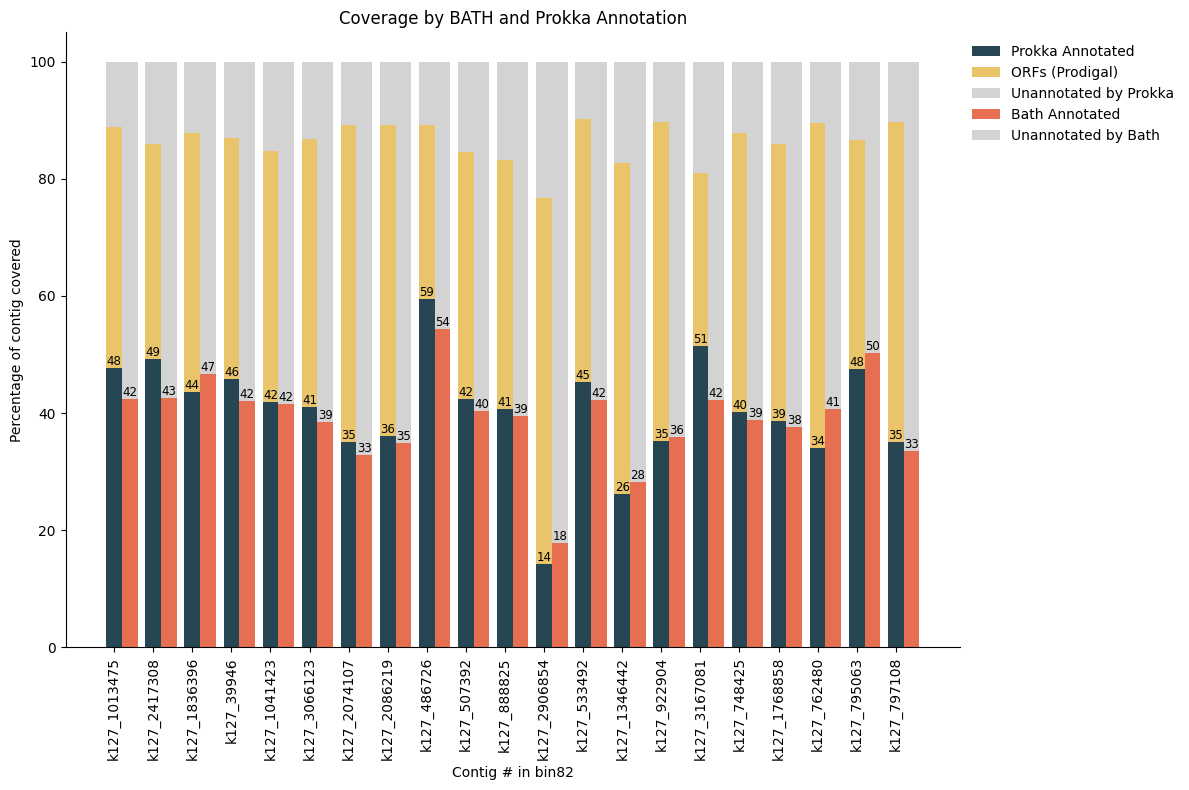

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 8))
n_contigs = len(contigs_info)
index = range(n_contigs)
bar_width = 0.4

bar2 = ax.bar(index, contigs_info['percent_covered_prokka'], bar_width, label='Prokka Annotated',color="#264653")
bar1 = ax.bar(index, contigs_info['percent_covered_prodigal'], bar_width, bottom=contigs_info['percent_covered_prokka'], label='ORFs (Prodigal)',color='#E9C46A')
bar3 = ax.bar(index, contigs_info['percent_uncovered_prokka'], bar_width, bottom=contigs_info['percent_covered_prodigal']+contigs_info['percent_covered_prokka'], label='Unannotated by Prokka',color='lightgrey')

bar4 = ax.bar([p + bar_width for p in index], contigs_info['percent_covered_bath'], bar_width, label='Bath Annotated',color="#E76F51")
bar5 = ax.bar([p + bar_width for p in index], contigs_info['percent_uncovered_bath'], bar_width, bottom=contigs_info['percent_covered_bath'], label='Unannotated by Bath',color='lightgrey')

for rect in bar2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{round(height)}', ha='center', va='bottom',fontsize=8.5)

for rect in bar4:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{round(height)}', ha='center', va='bottom',fontsize=8.5)

ax.set_xlabel('Contig # in bin82')
ax.set_ylabel('Percentage of contig covered')
ax.set_title('Coverage by BATH and Prokka Annotation')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)  # Ensure bottom line is visible
ax.spines['left'].set_visible(True)  # Ensure left line is visible
indices = range(n_contigs)
ax.set_xticks(indices)
ax.set_xticklabels(contigs_info['seq_id'], rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
def calculate_num_annotations(annotation_df, contig_id):
    annotations = annotation_df[annotation_df['seq_id'] == contig_id]
    return len(annotations)

# Initialize a list to hold results
results = []

for _, contig in contigs_info.iterrows():
    seq_id = contig['seq_id']

    # Calculate number of annotations for Prokka and BATH
    num_annotations_prokka = calculate_num_annotations(annotated_prokka_proteins, seq_id)
    num_annotations_bath = calculate_num_annotations(bath_protein, seq_id)

    results.append({
        'seq_id': seq_id,
        'Prokka Annotations Count': num_annotations_prokka,
        'BATH Annotations Count': num_annotations_bath
    })

    print(f"Contig {seq_id}: Prokka Annotations = {num_annotations_prokka}, BATH Annotations = {num_annotations_bath}")

# Convert results to DataFrame for easier manipulation and visualization
results_df = pd.DataFrame(results)
print(results_df)

Contig k127_1013475: Prokka Annotations = 74, BATH Annotations = 86
Contig k127_2417308: Prokka Annotations = 28, BATH Annotations = 29
Contig k127_1836396: Prokka Annotations = 23, BATH Annotations = 30
Contig k127_39946: Prokka Annotations = 29, BATH Annotations = 35
Contig k127_1041423: Prokka Annotations = 29, BATH Annotations = 39
Contig k127_3066123: Prokka Annotations = 59, BATH Annotations = 78
Contig k127_2074107: Prokka Annotations = 86, BATH Annotations = 111
Contig k127_2086219: Prokka Annotations = 33, BATH Annotations = 46
Contig k127_486726: Prokka Annotations = 79, BATH Annotations = 105
Contig k127_507392: Prokka Annotations = 9, BATH Annotations = 10
Contig k127_888825: Prokka Annotations = 27, BATH Annotations = 42
Contig k127_2906854: Prokka Annotations = 4, BATH Annotations = 7
Contig k127_533492: Prokka Annotations = 51, BATH Annotations = 64
Contig k127_1346442: Prokka Annotations = 8, BATH Annotations = 12
Contig k127_922904: Prokka Annotations = 43, BATH Annota

In [ ]:
results_df.sum()

seq_id                      k127_1013475k127_2417308k127_1836396k127_39946...
Prokka Annotations Count                                                  804
BATH Annotations Count                                                   1035
dtype: object

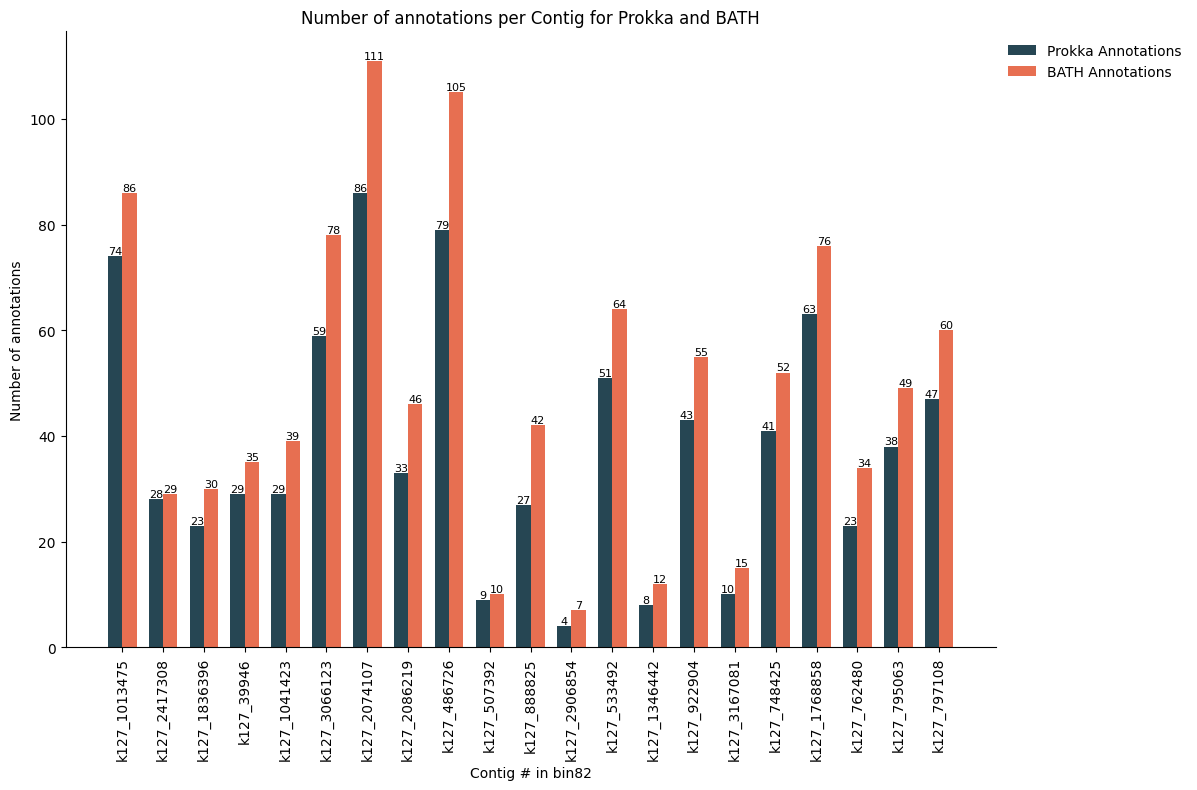

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
n_contigs = len(results_df)
index = range(n_contigs)
bar_width = 0.35

# Creating bars for Prokka annotations
prokka_bars = ax.bar(index, results_df['Prokka Annotations Count'], bar_width, label='Prokka Annotations', color="#264653")

# Creating bars for BATH annotations, offset by bar_width for side-by-side bars
bath_bars = ax.bar([p + bar_width for p in index], results_df['BATH Annotations Count'], bar_width, label='BATH Annotations', color="#E76F51")

# Adding text labels above the bars
for rect in prokka_bars:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=8)

for rect in bath_bars:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)  # Ensure bottom line is visible
ax.spines['left'].set_visible(True)  # Ensure left line is visible
ax.set_xlabel('Contig # in bin82')
ax.set_ylabel('Number of annotations')
ax.set_title('Number of annotations per Contig for Prokka and BATH')
ax.set_xticks([p + bar_width / 2 for p in index])  # Positioning the tick in the middle of the grouped bars
ax.set_xticklabels(results_df['seq_id'], rotation=90)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.show()


In [ ]:
def calculate_length_and_contig(annotation):
    if pd.isna(annotation):
        return None, None
    parts = annotation.split('\t')
    contig = parts[0]
    start = int(parts[1])
    end = int(parts[2])
    length = abs(end - start)
    return length, contig

# Apply the function to the BATH column
venn_data[['BATH length', 'contig_bath']] = venn_data['BATH'].apply(lambda x: pd.Series(calculate_length_and_contig(x)))

# Apply the function to the Prokka column
venn_data[['Prokka length', 'contig_prokka']] = venn_data['Prokka'].apply(lambda x: pd.Series(calculate_length_and_contig(x)))

# Fill missing values in contig_bath with contig_prokka and vice versa to create a single contig column
venn_data['contig'] = venn_data['contig_bath'].combine_first(venn_data['contig_prokka'])

# Drop the intermediate contig columns
venn_data = venn_data.drop(columns=['contig_bath', 'contig_prokka'])


In [ ]:
venn_data.label.value_counts()

label
BATH and Prokka Annotated      433
Prokka Unannotated             423
BATH and Prokka Unannotated     75
BATH                            18
Prokka Annotated                 2
Name: count, dtype: int64

In [ ]:
# Calculate the sum of lengths grouped by label and contig
grouped_sum = venn_data.groupby(['label', 'contig'])[['BATH length', 'Prokka length']].sum().reset_index()

# Verify the grouped sum
print(grouped_sum)

# Verify the value counts of labels in the grouped sum
print(grouped_sum['label'].value_counts())


                 label        contig  BATH length  Prokka length
0                 BATH  k127_1041423       4438.0            0.0
1                 BATH  k127_1346442        627.0            0.0
2                 BATH  k127_1768858       1045.0            0.0
3                 BATH  k127_1836396        776.0            0.0
4                 BATH  k127_2074107        620.0            0.0
..                 ...           ...          ...            ...
65  Prokka Unannotated   k127_762480          0.0        12957.0
66  Prokka Unannotated   k127_795063          0.0        15786.0
67  Prokka Unannotated   k127_797108          0.0        44587.0
68  Prokka Unannotated   k127_888825          0.0        17667.0
69  Prokka Unannotated   k127_922904          0.0        32532.0

[70 rows x 4 columns]
label
BATH and Prokka Annotated      20
Prokka Unannotated             20
BATH and Prokka Unannotated    16
BATH                           12
Prokka Annotated                2
Name: count, dtype: i

In [ ]:
df = pd.DataFrame(grouped_sum)
pivot_df = df.pivot_table(index='contig', columns='label', values='BATH length', fill_value=0, aggfunc='sum')
result_dict = pivot_df.reset_index().rename_axis(None, axis=1).to_dict(orient='list')
print(result_dict)

{'contig': ['k127_1013475', 'k127_1041423', 'k127_1346442', 'k127_1768858', 'k127_1836396', 'k127_2074107', 'k127_2086219', 'k127_2417308', 'k127_3066123', 'k127_3167081', 'k127_39946', 'k127_486726', 'k127_507392', 'k127_533492', 'k127_748425', 'k127_762480', 'k127_795063', 'k127_797108', 'k127_888825', 'k127_922904'], 'BATH': [0, 4438, 627, 1045, 776, 620, 889, 0, 0, 950, 281, 1171, 0, 0, 0, 206, 585, 421, 0, 0], 'BATH and Prokka Annotated': [40303, 17305, 7629, 23865, 11304, 37157, 21942, 5807, 23605, 4950, 15883, 39578, 5553, 31975, 16352, 16439, 7957, 18050, 20997, 30822], 'BATH and Prokka Unannotated': [1404, 0, 0, 5589, 4202, 3169, 4748, 1782, 5016, 0, 958, 5741, 0, 2324, 1567, 3532, 1069, 3493, 3647, 3744], 'Prokka Annotated': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Prokka Unannotated': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


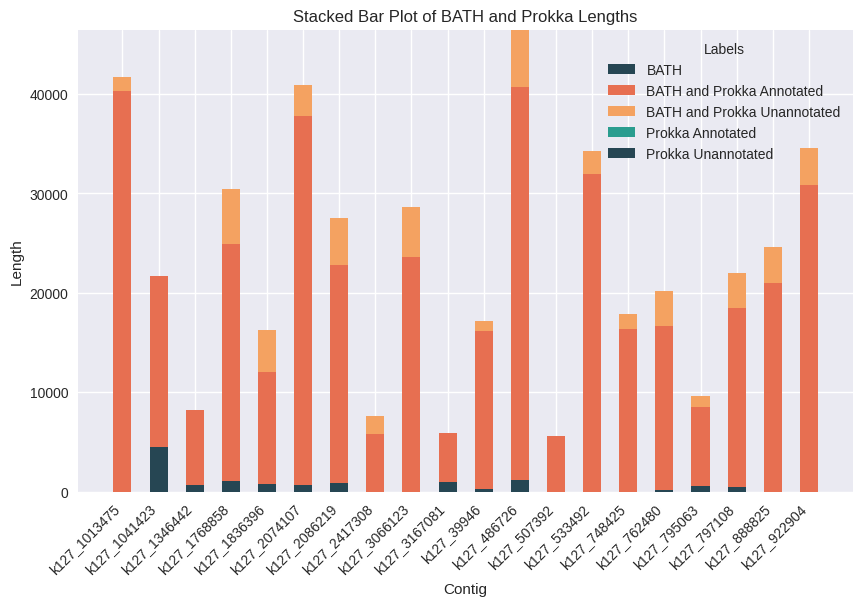

In [ ]:
df = pd.DataFrame(grouped_sum)

# Pivot the DataFrame
pivot_df = df.pivot_table(index='contig', columns='label', values='BATH length', fill_value=0, aggfunc='sum')

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar positions
bar_width = 0.5
bar_positions = range(len(pivot_df))

# Plot each segment
bottoms = [0] * len(pivot_df)
colors = ['#264653', '#E76F51', '#F4A261', '#2A9D8F']  # Custom colors

for i, label in enumerate(pivot_df.columns):
    ax.bar(bar_positions, pivot_df[label], bottom=bottoms, width=bar_width, label=label, color=colors[i % len(colors)])
    bottoms = [bottoms[j] + pivot_df[label].iloc[j] for j in range(len(pivot_df))]

# Customize the plot
ax.set_xticks(bar_positions)
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')
ax.set_xlabel('Contig')
ax.set_ylabel('Length')
ax.set_title('Stacked Bar Plot of BATH and Prokka Lengths')
ax.legend(title='Labels')

# Show the plot
plt.show()

In [ ]:
def calculate_length_and_contig(annotation):
    if pd.isna(annotation):
        return None, None
    parts = annotation.split('\t')
    contig = parts[0]
    start = int(parts[1])
    end = int(parts[2])
    length = abs(end - start)
    return length, contig

# Apply the function to the BATH column
venn_data[['BATH length', 'contig_bath']] = venn_data['BATH'].apply(lambda x: pd.Series(calculate_length_and_contig(x)))

# Apply the function to the Prokka column
venn_data[['Prokka length', 'contig_prokka']] = venn_data['Prokka'].apply(lambda x: pd.Series(calculate_length_and_contig(x)))

# Fill missing values in contig_bath with contig_prokka and vice versa to create a single contig column
venn_data['contig'] = venn_data['contig_bath'].combine_first(venn_data['contig_prokka'])

# Drop the intermediate contig columns
venn_data = venn_data.drop(columns=['contig_bath', 'contig_prokka'])

# Merge with contigs_info to get the full length of each contig
venn_data = venn_data.merge(contigs_info, left_on='contig', right_on='seq_id', how='left').drop(columns=['seq_id'])

# Calculate the sum of lengths grouped by label and contig
grouped_sum = venn_data.groupby(['label', 'contig', 'length'])[['BATH length', 'Prokka length']].sum().reset_index()

# Calculate the total annotated length
grouped_sum['total_annotated_length'] = grouped_sum['BATH length'] + grouped_sum['Prokka length']

# Calculate the percentage covered by each label
grouped_sum['percentage_covered'] = (grouped_sum['total_annotated_length'] / grouped_sum['length']) * 100

# Calculate the unannotated percentage for each contig
unannotated = grouped_sum.groupby('contig')['percentage_covered'].sum().reset_index()
unannotated['unannotated_percentage'] = 100 - unannotated['percentage_covered']
unannotated = unannotated[['contig', 'unannotated_percentage']]

# Add unannotated to the grouped_sum
unannotated['label'] = 'Unannotated'
unannotated['BATH length'] = 0
unannotated['Prokka length'] = 0
unannotated = unannotated.rename(columns={'unannotated_percentage': 'percentage_covered'})
grouped_sum = pd.concat([grouped_sum, unannotated], ignore_index=True)

# Pivot the DataFrame
pivot_df = grouped_sum.pivot_table(index='contig', columns='label', values='percentage_covered', fill_value=0)

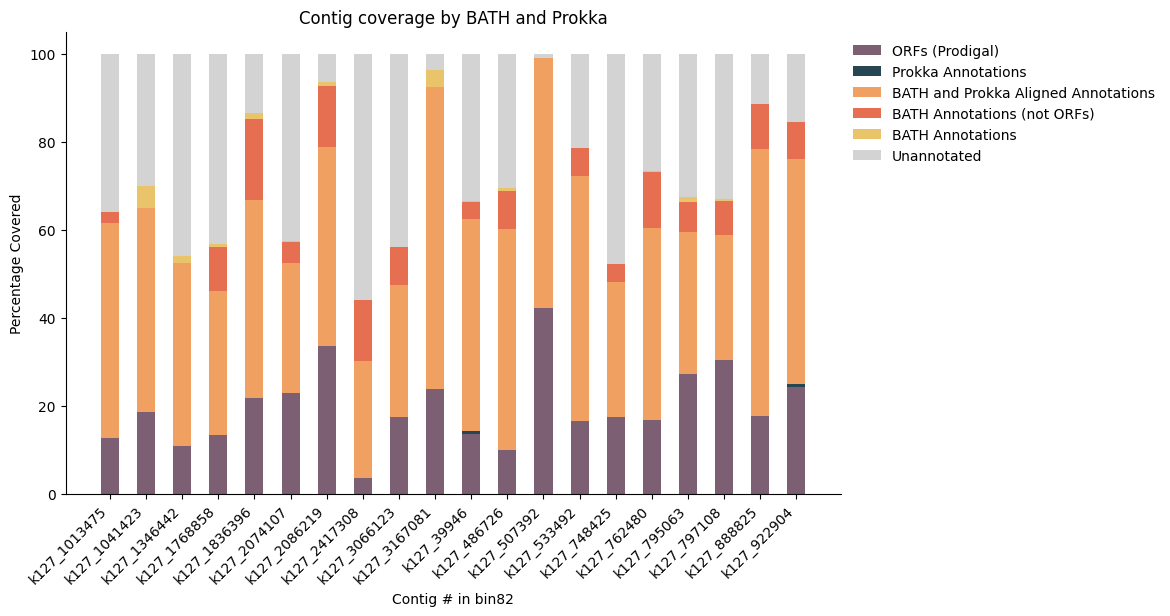

In [ ]:

plt.style.use('default')
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar positions
bar_width = 0.5
bar_positions = range(len(pivot_df))

# Plot each segment
bottoms = [0] * len(pivot_df)


label_order = ['Prokka Unannotated','Prokka Annotated','BATH and Prokka Annotated', 'BATH and Prokka Unannotated', 'BATH', 'Unannotated']
custom_labels = {
    'BATH and Prokka Annotated': 'BATH and Prokka Aligned Annotations',
    'Prokka Unannotated': 'ORFs (Prodigal)',
    'BATH and Prokka Unannotated': 'BATH Annotations (not ORFs)',
    'BATH': 'BATH Annotations',
    'Unannotated': 'Unannotated',
    'Prokka Annotated':'Prokka Annotations'
}

# Pivot the DataFrame with the specified order
pivot_df = grouped_sum.pivot_table(index='contig', columns='label', values='percentage_covered', fill_value=0).reindex(columns=label_order, fill_value=0)

# Rename the columns with custom labels
pivot_df.columns = [custom_labels[label] for label in pivot_df.columns]

colors = ['#7C5F72', '#264653', '#f0a060', '#E76F51', '#E9C46A', '#D3D3D3']  # Custom colors including gray for unannotated

for i, label in enumerate(pivot_df.columns):
    ax.bar(bar_positions, pivot_df[label], bottom=bottoms, width=bar_width, label=label, color=colors[i % len(colors)])
    bottoms = [bottoms[j] + pivot_df[label].iloc[j] for j in range(len(pivot_df))]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)  # Ensure bottom line is visible
ax.spines['left'].set_visible(True)  # Ensure left line is visible
ax.set_xlabel('Contig # in bin82')
ax.set_xticks(bar_positions)
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')
ax.set_ylabel('Percentage Covered')
ax.set_title('Contig coverage by BATH and Prokka')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
# Show the plot
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'venn_data' is already loaded as a DataFrame

# Group the data
grouped_sum = venn_data.groupby(['label', 'contig']).size().reset_index(name='count')

# Create a pivot table
pivot_df = grouped_sum.pivot_table(index='contig', columns='label', values='count', fill_value=0)

# Define the order and colors for the annotations
order_bar1 = ['BATH and Prokka Annotated', 'BATH and Prokka Unannotated', 'BATH']
order_bar2 = ['BATH and Prokka Annotated','Prokka Annotated']

colors = {
    'BATH': '#E76F51',
    'BATH and Prokka Annotated': '#7C5F72',
    'BATH and Prokka Unannotated': '#F4A261',
    'Prokka Annotated': '#264653'
}

custom_labels = {
    'BATH and Prokka Annotated': 'BATH and Prokka Aligned Annotations',
    'Prokka Unannotated': 'ORFs (Prodigal)',
    'BATH and Prokka Unannotated': 'BATH Annotations (not ORFs)',
    'BATH': 'BATH Annotations',
    'Unannotated': 'Unannotated',
    'Prokka Annotated': 'Prokka Annotations'
}

# Separate the data for the two bars
bar1_data = pivot_df[order_bar1]
bar2_data = pivot_df[order_bar2]

# Plot the data as stacked bar charts
fig, ax = plt.subplots(figsize=(14, 8))

# Define the positions for the bars with a small gap between them within each group
bar_width = 0.35
group_width = 1.0  # Width of the space for each group of bars
bar_positions1 = np.arange(len(pivot_df)) * group_width
bar_positions2 = bar_positions1 + bar_width + 0.03  # Adding a small gap between bar 1 and bar 2

# Plot Bar 1
bottoms1 = [0] * len(pivot_df)
for label in order_bar1:
    ax.bar(bar_positions1, bar1_data[label], bottom=bottoms1, width=bar_width, label=custom_labels[label] if custom_labels[label] not in ax.get_legend_handles_labels()[1] else "", color=colors[label])
    bottoms1 = [bottoms1[i] + bar1_data[label][i] for i in range(len(pivot_df))]

# Plot Bar 2
bottoms2 = [0] * len(pivot_df)
for label in order_bar2:
    ax.bar(bar_positions2, bar2_data[label], bottom=bottoms2, width=bar_width, label=custom_labels[label] if custom_labels[label] not in ax.get_legend_handles_labels()[1] else "", color=colors[label])
    bottoms2 = [bottoms2[i] + bar2_data[label][i] for i in range(len(pivot_df))]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_title('Number of annotations per contig by BATH and Prokka')
ax.set_ylabel('Counts')
ax.set_xlabel('Contig # in bin82')
ax.set_xticks(bar_positions1 + bar_width / 2 + 0.025)
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.show()


### Plotting length distributions

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to extract lengths
def extract_length(annotation):
    if pd.isna(annotation):
        return 0
    parts = annotation.split('\t')
    start = int(parts[1])
    end = int(parts[2])
    return end - start + 1

# Calculate lengths and store in lists
lengths = []
labels = []
annotation_type = []

for _, row in venn_data.iterrows():
    prokka_length = extract_length(row['Prokka'])
    bath_length = extract_length(row['BATH'])

    if prokka_length > 0:
        lengths.append(prokka_length)
        labels.append(row['label'])
        annotation_type.append('Prokka')
    if bath_length > 0:
        lengths.append(bath_length)
        labels.append(row['label'])
        annotation_type.append('BATH')

# Create a DataFrame for plotting
lengths_df = pd.DataFrame({
    'Length': lengths,
    'Label': labels,
    'Annotation': annotation_type
})

# Combine 'Label' and 'Annotation' for hue
lengths_df['Label_Annotation'] = lengths_df['Label'] + ' (' + lengths_df['Annotation'] + ')'

In [ ]:
lengths_df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


palette = {
    'Prokka Unannotated (Prokka)': '#E9C46A',
    'Prokka Annotated (Prokka)': '#264653',
    'BATH and Prokka Annotated (BATH)': '#CBC3E3',
    'BATH and Prokka Annotated (Prokka)': '#7C5F72',
    'BATH and Prokka Unannotated (BATH)': '#F4A261',
    'BATH and Prokka Unannotated (Prokka)': '#E9C46A',
    'BATH (BATH)': '#E76F51'
}

custom_labels = ['ORFs (Prodigal)', 'Prokka Annotations', 'BATH Annotations (not ORF)', 'BATH and Prokka\nAligned Annotations', 'BATH Annotations (ORFs)']

custom_labels2 = ['ORFs (Prodigal)', 'Prokka Annotations', 'BATH Annotations (not ORF)', 'BATH and Prokka\nAligned Annotations (Prokka)', 'BATH and Prokka\nAligned Annotations (BATH)', 'ORFs (Prodigal)', 'BATH Annotations (ORFs)']

plt.style.use('default')
fig, ax = plt.subplots(figsize=(15, 8))

# Define the order for labels and annotations
label_order = lengths_df['Label'].unique().tolist()
annotation_order = lengths_df['Annotation'].unique().tolist()

sns.stripplot(x='Label', y='Length', hue='Label_Annotation', data=lengths_df, dodge=True, jitter=True, alpha=0.5, edgecolor='black', linewidth=0.5, ax=ax, palette=palette)
#sns.boxplot(x='Label', y='Length', hue='Label_Annotation', data=lengths_df, palette=palette, ax=ax)


sns.boxplot(x='Label', y='Length', hue='Label_Annotation', data=lengths_df, palette=palette, ax=ax, width=0.8)


# Customize the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_title('Length distributions of Prokka vs BATH annotations')
ax.set_xlabel('Annotation Source')
ax.set_ylabel('Length of Individual Annotations')
ax.set_xticklabels(custom_labels, rotation=45, ha='right')

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), custom_labels2, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
def parse_prokka(row):
    if pd.isna(row):
        return np.nan

    parts = row.split('\t')
    last_element = parts[-1]

    if 'UniProt' in last_element:
        return 'Blast'
    elif 'IS' in last_element:
        return 'ISFinder'
    elif 'MF' in last_element:
        return 'HMMER'
    else:
        return 'Prodigal'

# Apply the function to the 'Prokka' column and create the new 'Prokka_SW' column
venn_data['Prokka_SW'] = venn_data['Prokka'].apply(parse_prokka)

print(venn_data['Prokka_SW'])

In [ ]:
filtered_data = venn_data.dropna(subset=['BATH length', 'Prokka length', 'Prokka_SW'])

# Define the pastel palette with the requested colors
palette2 = {'Blast': '#FFB7B2', 'ISFinder': '#FDE293', 'HMMER': '#B2D8B2', 'Prodigal': '#9BB7C7'}

# Plot the data
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='BATH length', y='Prokka length', hue='Prokka_SW', data=filtered_data, palette=palette2, s=100, alpha=0.7, edgecolor='black')

# Plot the 45-degree line
max_length = max(filtered_data['BATH length'].max(), filtered_data['Prokka length'].max())
plt.plot([0, max_length], [0, max_length], color='black', linestyle='--', linewidth=1)
plt.xlim(0, 6000)
plt.ylim(0, 6000)
plt.title('Length comparison of BATH and Prokka aligned annotations')
plt.xlabel('BATH annotation length')
plt.ylabel('Prokka annotation length')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.legend(title='Prokka Annotation\n Origin', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

In [ ]:
venn_data.to_excel("Size_check.xlsx")

### Checking frameshifts for every group

In [ ]:
bath_data = venn_data[(venn_data['label'] != "Prokka Annotated") & (venn_data['label'] != "Prokka Unannotated")]

In [ ]:
shifts = []
for index, rows in bath_data.iterrows():
  shifts.append(rows['BATH'].split("\t")[-1])

In [ ]:
frameshifts = pd.DataFrame()
frameshifts['label'] = bath_data['label']
frameshifts['shifts'] = shifts
frameshifts['shifts'] = frameshifts['shifts'].astype(int)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
fig, ax = plt.subplots(figsize=(14, 8))

palette = {
    'Prokka Unannotated': '#E9C46A',
    'Prokka Annotated ': '#264653',
    'BATH and Prokka Annotated': '#7C5F72',
    'BATH and Prokka Unannotated': '#F4A261',
    'BATH': '#E76F51'
}

sns.violinplot(x='label', y='shifts', data=frameshifts, inner=None, palette=palette, ax=ax)
sns.stripplot(x='label', y='shifts', data=frameshifts, color='grey', edgecolor='black', linewidth=0.5, ax=ax, alpha=0.5)

# Calculate and plot median and quartiles
medians = frameshifts.groupby(['label'])['shifts'].median()
quartiles = frameshifts.groupby(['label'])['shifts'].quantile([0.25, 0.75]).unstack()

for idx, median in enumerate(medians):
    plt.axhline(median, color='black', linestyle='--', linewidth=1)
    plt.text(idx, median, f'{median:.1f}', ha='center', va='center', color='white', fontweight='bold')

for idx, quartile in enumerate(quartiles.itertuples(index=False, name=None)):
    plt.axhline(quartile[0], color='black', linestyle='--', linewidth=0.5)
    plt.axhline(quartile[1], color='black', linestyle='--', linewidth=0.5)

custom_labels = ['BATH Annotations(not ORFs)','BATH and Prokka \n Aligned Annotations','BATH annotations (ORFs)']
ax.set_xticklabels(custom_labels, rotation=45, ha='right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)  # Ensure bottom line is visible
ax.spines['left'].set_visible(True)
ax.set_title('Frameshifts for each BATH annotation')
ax.set_xlabel('BATH annotation sets')
ax.set_ylabel('# of frameshifts')

plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
swarmplot = sns.swarmplot(x='label', y='shifts', data=frameshifts)
plt.title('BATH annotations for each category')
plt.xlabel('Label')
plt.ylabel('Shifts')
plt.show()